# Proyecto 1 - DAE + VAE

## Por Francisco Tinoco y Juan Pedro Ley Valdez

# Parte 1: Creación del Dataset


## Obtención de imágenes:



Buscaremos recolectar imágenes de las clases: "mouse" y "sandalias", para eso se usará la librería de Selenium para hacer scraping.

In [52]:
pip install selenium pillow requests tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 36.6 MB/s eta 0:00:00


In [ ]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

options = webdriver.ChromeOptions()
options.add_argument("--headless")  # No mostrar ventana

# Forma correcta de inicializar el WebDriver en Selenium 4+
driver = webdriver.Chrome(service=webdriver.ChromeService(ChromeDriverManager().install()), options=options)

driver.get("https://www.google.com")
print(driver.title)
driver.quit()

Google


Aquí usamos WebDriver Manager para evitar descargas manuales de ChromeDriver

In [4]:
import os
import time
import requests
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from PIL import Image
from io import BytesIO
import numpy as np

In [ ]:
# Configurar el WebDriver
def get_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # No mostrar ventana
    options.add_argument("--disable-gpu")  # Mejor estabilidad en headless
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    return driver

# Función para descargar imágenes
def download_images(query, num_images, save_dir):
    driver = get_driver()
    search_url = f"https://www.google.com/search?q={query}&tbm=isch"
    driver.get(search_url)

    # Esperar a que las imágenes carguen
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "img")))

    # Simular scroll para cargar más imágenes
    body = driver.find_element(By.TAG_NAME, "body")
    for _ in range(5):  # Ajusta el número de scrolls si necesitas más imágenes
        body.send_keys(Keys.END)
        time.sleep(2)

    # Obtener imágenes
    images = driver.find_elements(By.CSS_SELECTOR, "img")
    os.makedirs(save_dir, exist_ok=True)

    count = 0
    for img in images:
        if count >= num_images:
            break
        try:
            img_url = img.get_attribute("src") or img.get_attribute("data-src")
            if img_url and img_url.startswith("http"):  # Evitar imágenes en base64
                img_data = requests.get(img_url).content
                img = Image.open(BytesIO(img_data))
                img.save(os.path.join(save_dir, f"{query.replace(' ', '_')}_{count}.jpg"))
                count += 1
        except Exception as e:
            print(f"Error descargando imagen {count}: {e}")

    driver.quit()
    print(f"Descargadas {count} imágenes de '{query}' en {save_dir}")




In [ ]:
download_images("mouse computadora", 1000, "dataset/mouse")
download_images("sandalias", 1000, "dataset/sandalias")

Error descargando imagen 3: cannot identify image file <_io.BytesIO object at 0x000001AF11DEC540>
Error descargando imagen 13: cannot write mode P as JPEG
Error descargando imagen 26: cannot write mode P as JPEG
Error descargando imagen 46: cannot write mode P as JPEG
Error descargando imagen 69: cannot write mode P as JPEG
Error descargando imagen 80: cannot write mode RGBA as JPEG
Error descargando imagen 81: cannot write mode P as JPEG
Error descargando imagen 82: cannot write mode P as JPEG
Error descargando imagen 83: cannot write mode P as JPEG
Error descargando imagen 84: cannot write mode P as JPEG
Error descargando imagen 85: cannot write mode RGBA as JPEG
Error descargando imagen 86: cannot write mode P as JPEG
Error descargando imagen 86: cannot write mode P as JPEG
Error descargando imagen 86: cannot write mode P as JPEG
Error descargando imagen 87: cannot write mode RGBA as JPEG
Error descargando imagen 88: cannot write mode RGBA as JPEG
Error descargando imagen 89: cannot

Se configuró un WebDriver para utilizar Google Chrome en modo headless (sin interfaz gráfica) y con opciones optimizadas para estabilidad, ya que sin estas, fallaba el descargar las imágenes.

Se implementó una función para buscar imágenes en Google Images, simular scroll para cargar más resultados y descargar las imágenes encontradas.

Manejamos excepciones para evitar interrupciones en el scraping y filtramos imágenes inválidas.

# Extensión de Chrome :

realizar descargas masiva de imágenes es utilizando la extensión de chrome **Download all images** se puede obtener en el siguiente link:

 https://chrome.google.com/webstore/detail/download-all-images/ifipmflagepipjokmbdecpmjbibjnakm?hl=en


## Procesamiento de datos:



In [1]:
import zipfile
import os

# Definir las rutas de los archivos ZIP
zip_path1 = "/content/mouse.zip"  
zip_path2 = "/content/sandalias.zip"  

# Definir las carpetas de destino
extract_path1 = "/content/dataset1"
extract_path2 = "/content/dataset2"

# Crear las carpetas de destino si no existen
os.makedirs(extract_path1, exist_ok=True)
os.makedirs(extract_path2, exist_ok=True)

# Función para descomprimir un archivo ZIP
def unzip_file(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Archivos extraídos en: {extract_path}")

# Descomprimir los archivos ZIP
unzip_file(zip_path1, extract_path1)
unzip_file(zip_path2, extract_path2)

# Verificar los archivos extraídos
print("Contenido del primer ZIP:")
print(os.listdir(extract_path1))

print("Contenido del segundo ZIP:")
print(os.listdir(extract_path2))


Archivos extraídos en: /content/dataset1
Archivos extraídos en: /content/dataset2
Contenido del primer ZIP:
['mouse']
Contenido del segundo ZIP:
['sandalias']


In [2]:
from sklearn.utils import shuffle
import random

input_dirs = {
    "mouse": "dataset1/mouse",
    "sandalias": "dataset2/sandalias"
}

img_size = (128, 128)
label_map = {"mouse": 0, "sandalias": 1}

def load_and_split_images():
    train_images, train_labels = [], []
    val_images, val_labels = [], []
    test_images, test_labels = [], []

    for category, input_dir in input_dirs.items():
        images = os.listdir(input_dir)
        random.shuffle(images)  # Mezclar imágenes dentro de la clase

        num_train = int(len(images) * 0.7)
        num_val = int(len(images) * 0.2)

        for i, img_name in enumerate(images):
            img_path = os.path.join(input_dir, img_name)
            try:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(img_size)
                img_array = np.array(img) / 255.0

                if i < num_train:
                    train_images.append(img_array)
                    train_labels.append(label_map[category])
                elif i < num_train + num_val:
                    val_images.append(img_array)
                    val_labels.append(label_map[category])
                else:
                    test_images.append(img_array)
                    test_labels.append(label_map[category])

            except Exception as e:
                print(f"Error procesando {img_name}: {e}")

    print("✅ Procesamiento y división completados.")

    # Convertir listas a arrays de NumPy
    train_images, train_labels = shuffle(np.array(train_images), np.array(train_labels))
    val_images, val_labels = shuffle(np.array(val_images), np.array(val_labels))
    test_images, test_labels = shuffle(np.array(test_images), np.array(test_labels))

    return train_images, train_labels, val_images, val_labels, test_images, test_labels

In [5]:
# Cargar los datos
train_images, train_labels, val_images, val_labels, test_images, test_labels = load_and_split_images()

✅ Procesamiento y división completados.


In [6]:
train_images.shape

(551, 128, 128, 3)

In [7]:
test_images.shape

(81, 128, 128, 3)

In [8]:
val_images.shape

(157, 128, 128, 3)

In [ ]:
# Contar cuántas imágenes hay de cada clase
import numpy as np

print("Train set:")
print("Mouses:", np.sum(train_labels == 0))
print("Sandalias:", np.sum(train_labels == 1))

print("\nValidation set:")
print("Mouses:", np.sum(val_labels == 0))
print("Sandalias:", np.sum(val_labels == 1))

print("\nTest set:")
print("Mouses:", np.sum(test_labels == 0))
print("Sandalias:", np.sum(test_labels == 1))

Train set:
Mouses: 291
Sandalias: 260

Validation set:
Mouses: 83
Sandalias: 74

Test set:
Mouses: 43
Sandalias: 38


Redimensionamos las imágenes a 128x128, normalizamos los valores de los pixeles en un valor entre 0 y 1, y dividmos las imágenes en train, test y validation.

# Parte 2: Denoising Autoencoder (DAE)


In [ ]:
# Funcion para añadir ruido gausiano
import cv2

def add_gaussian_noise(image, mean=0, std=0.1):
    """
    Agrega ruido gaussiano a una imagen.
    - image: imagen normalizada (valores entre 0 y 1).
    - mean: media del ruido.
    - std: desviación estándar del ruido.
    """
    noise = np.random.normal(mean, std, image.shape)  # Crear ruido
    noisy_image = image + noise  # Sumar ruido a la imagen
    noisy_image = np.clip(noisy_image, 0, 1)  # Asegurar que los valores sigan entre 0 y 1
    return noisy_image

# Funcion para añadir ruido de sal y pimienta


def add_salt_and_pepper_noise(image, prob=0.02):
    """
    Agrega ruido de sal y pimienta a una imagen.
    - image: imagen normalizada (valores entre 0 y 1).
    - prob: probabilidad de que un píxel sea afectado.
    """
    noisy_image = image.copy()
    total_pixels = image.size

    # Índices de los píxeles que se modificarán
    num_salt = int(total_pixels * prob / 2)  # Mitad serán blancos
    num_pepper = int(total_pixels * prob / 2)  # Mitad serán negros

    # Coordenadas aleatorias para píxeles blancos
    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 1  # Píxeles blancos

    # Coordenadas aleatorias para píxeles negros
    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0  # Píxeles negros

    return noisy_image


Estas funciones se encargarán de aplicar ruido gausiano y de sal y pimienta a las imágenes

In [ ]:
# Aplicar ruido a las imágenes de entrenamiento y prueba
train_images_noisy_gaussian = np.array([add_gaussian_noise(img) for img in train_images])
train_images_noisy_sp = np.array([add_salt_and_pepper_noise(img) for img in train_images])

val_images_noisy_gaussian = np.array([add_gaussian_noise(img) for img in val_images])
val_images_noisy_sp = np.array([add_salt_and_pepper_noise(img) for img in val_images])

test_images_noisy_gaussian = np.array([add_gaussian_noise(img) for img in test_images])
test_images_noisy_sp = np.array([add_salt_and_pepper_noise(img) for img in test_images])

print("✅ Ruido agregado a las imágenes correctamente.")


✅ Ruido agregado a las imágenes correctamente.


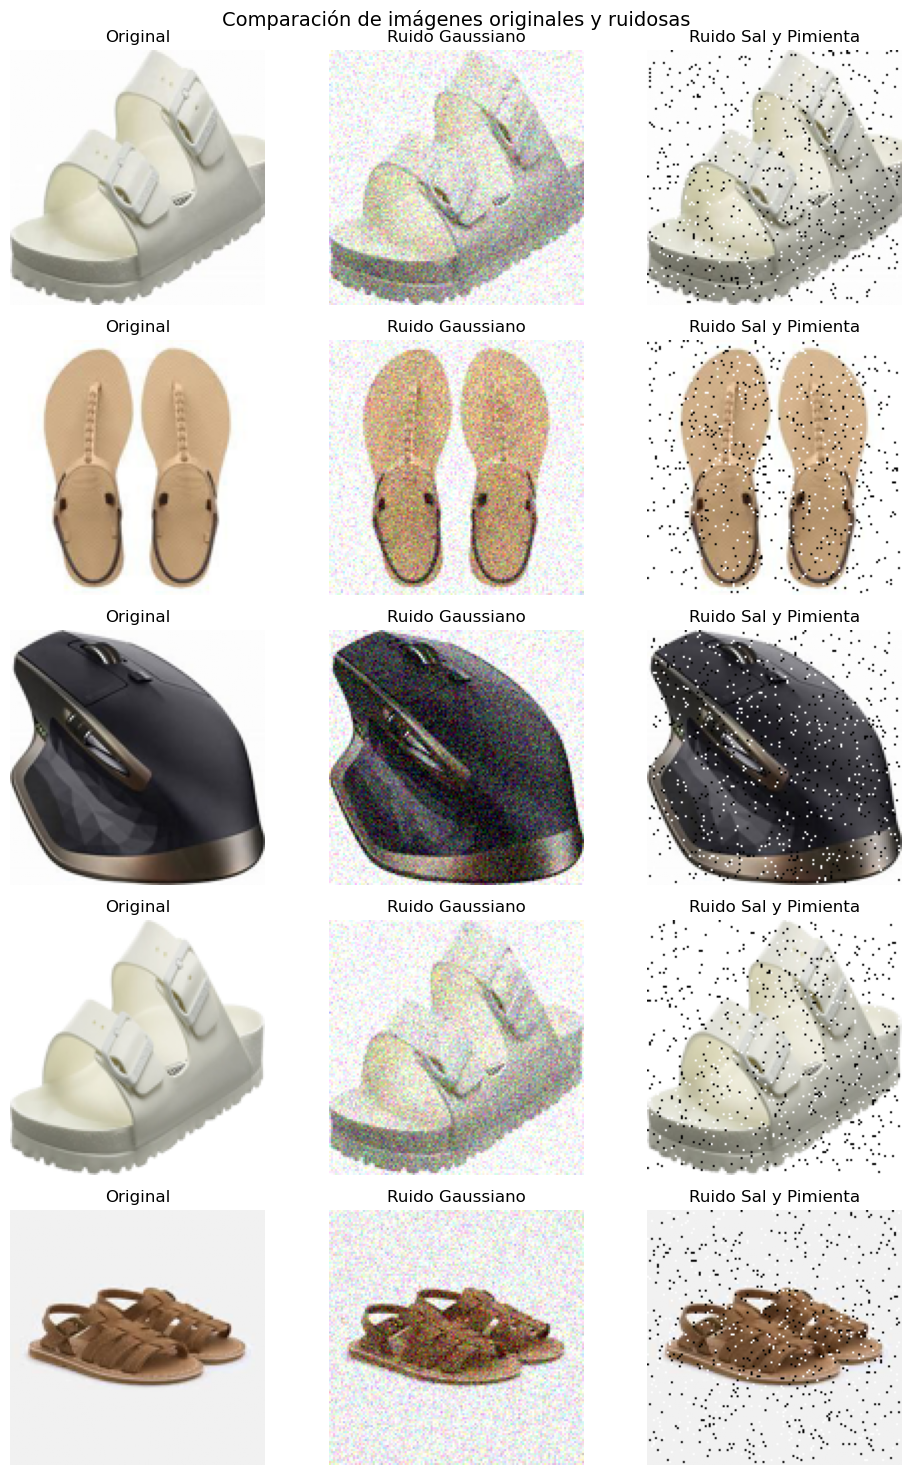

In [ ]:
import matplotlib.pyplot as plt

def show_noisy_images(original, noisy_gaussian, noisy_sp, num_samples=5):
    """
    Muestra imágenes originales y sus versiones con ruido.
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))
    fig.suptitle("Comparación de imágenes originales y ruidosas", fontsize=14)

    for i in range(num_samples):
        # Imagen original
        axes[i, 0].imshow(original[i])
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")

        # Imagen con ruido gaussiano
        axes[i, 1].imshow(noisy_gaussian[i])
        axes[i, 1].set_title("Ruido Gaussiano")
        axes[i, 1].axis("off")

        # Imagen con ruido de sal y pimienta
        axes[i, 2].imshow(noisy_sp[i])
        axes[i, 2].set_title("Ruido Sal y Pimienta")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Llamamos a la función con 5 imágenes de ejemplo
show_noisy_images(train_images, train_images_noisy_gaussian, train_images_noisy_sp, num_samples=5)

## Construcción del DAE

Este modelo se entrenará con imágenes sucias con ruido gausiano y buscaremos evaluarlo con imágenes de prueba limpias.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

In [ ]:
def build_denoising_autoencoder(input_shape=(128, 128, 3)):  
    input_layer = Input(shape=input_shape)

    # 🔹 ENCODER: Más filtros para mejor extracción de características
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(input_layer)
    x = MaxPooling2D((2, 2), padding="same")(x)

    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2), padding="same")(x)

    x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2), padding="same")(x)

    # 🔹 BOTTLENECK
    x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)

    # 🔹 DECODER: Más capas para mejorar la reconstrucción del color
    x = Conv2DTranspose(256, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x)

    model = Model(input_layer, output_layer)
    return model

# 📌 Crear y compilar el modelo
dae = build_denoising_autoencoder()
dae.compile(optimizer="adam", loss="mse")  # Podemos cambiar MSE más adelante

# 📌 Ver la arquitectura del modelo
dae.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_79 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_80 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 32, 32, 256)       2951

In [ ]:
# Fit del modelo
dae.fit(train_images_noisy_gaussian, train_images,
        epochs=20, batch_size=16,
        validation_data=(val_images_noisy_gaussian, val_images))

Epoch 1/20
46/46 [==============================] - 149s 3s/step - loss: 0.0741 - val_loss: 0.0238
Epoch 2/20
46/46 [==============================] - 140s 3s/step - loss: 0.0165 - val_loss: 0.0142
Epoch 3/20
46/46 [==============================] - 135s 3s/step - loss: 0.0111 - val_loss: 0.0098
Epoch 4/20
46/46 [==============================] - 147s 3s/step - loss: 0.0095 - val_loss: 0.0090
Epoch 5/20
46/46 [==============================] - 133s 3s/step - loss: 0.0080 - val_loss: 0.0074
Epoch 6/20
46/46 [==============================] - 131s 3s/step - loss: 0.0070 - val_loss: 0.0070
Epoch 7/20
46/46 [==============================] - 130s 3s/step - loss: 0.0063 - val_loss: 0.0069
Epoch 8/20
46/46 [==============================] - 130s 3s/step - loss: 0.0057 - val_loss: 0.0056
Epoch 9/20
46/46 [==============================] - 130s 3s/step - loss: 0.0053 - val_loss: 0.0054
Epoch 10/20
46/46 [==============================] - 133s 3s/step - loss: 0.0051 - val_loss: 0.0051
Epoch 11/

## Tracking en Weights & Biases:



Registrar el entrenamiento, métricas y pérdidas en Weights & Biases (W&B).



In [ ]:
pip install wandb

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/20.2 MB ? eta -:--:--
    --------------------------------------- 0.3/20.2 MB ? eta -:--:--
   - -------------------------------------- 0.8/20.2 MB 2.4 MB/s eta 0:00:09
   -- ------------------------------------- 1.3/20.2 MB 2.3 MB/s eta 0:00:09
   --- ------------------------------------ 1.8/20.2 MB 2.5 MB/s eta 0:00:08
   ---- ----------------------------------- 2.4/20.2 MB 2.4 MB/s eta 0:00:08
   ----- ---------------------------------- 2.9/20.2 MB 2.4 MB/s eta 0:00:08
   ------ --------------------------------- 3.4/20.2 MB 2.4 MB/s eta 0:00:07
   ------- -------------------------------- 3.9/20.2 MB 2.4 MB/s eta 0:00:07
   -------- ------------------------------- 4.5/20.2 MB 2.4 MB/s eta 0:00:07
   --------- ------------------------------ 5.0/20.2 MB 2.4 MB/s eta 0:00:07
   ---------- ----------------------------- 5.5/20.2 MB 2.4 MB/s eta 0:00:07
   ----------- 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.12.1 requires numpy>=1.12, which is not installed.
formulaic 0.5.2 requires numpy>=1.16.5, which is not installed.
lifelines 0.27.4 requires numpy>=1.14.0, which is not installed.
pymc 5.9.2 requires numpy>=1.15.0, which is not installed.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, which is not installed.
pytensor 2.17.4 requires numpy>=1.17.0, which is not installed.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, which is not installed.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", which is not installed.
transformers 4.44.1 requires numpy>=1.17, which is not installed.
anaconda-cloud-auth 0.1.4 requires pydantic<2.0, but you have pydantic 2.10.6 which is incompatible.
prefect 3.0.3 requires anyio<5.0.0,>=4.4.0, but you have anyio 4.2.0 which is incompatible.
prefect 3.0.3 requi

In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Francisco\_netrc
wandb: Currently logged in as: jose-tinoco (jose-tinoco-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(project="denoising-autoencoder", name="exp_gaussian_noise")

In [ ]:
from wandb.integration.keras import WandbCallback

In [ ]:
# Agregar el callback a fit()
dae.fit(train_images_noisy_gaussian, train_images,
                epochs=20, batch_size=32,
                validation_data=(test_images_noisy_gaussian, test_images),
                callbacks=[WandbCallback()])


wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
22/22 [==============================] - ETA: 0s - loss: 0.0059

C:\Users\ju4np\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best)... Done. 0.1s


22/22 [==============================] - 26s 1s/step - loss: 0.0059 - val_loss: 0.0053
Epoch 2/20
22/22 [==============================] - ETA: 0s - loss: 0.0053

C:\Users\ju4np\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best)... Done. 0.1s


22/22 [==============================] - 23s 1s/step - loss: 0.0053 - val_loss: 0.0051
Epoch 3/20
22/22 [==============================] - ETA: 0s - loss: 0.0052

C:\Users\ju4np\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best)... Done. 0.1s


22/22 [==============================] - 23s 1s/step - loss: 0.0052 - val_loss: 0.0049
Epoch 4/20
22/22 [==============================] - 22s 994ms/step - loss: 0.0051 - val_loss: 0.0057
Epoch 5/20
22/22 [==============================] - 21s 973ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 6/20
22/22 [==============================] - ETA: 0s - loss: 0.0050

C:\Users\ju4np\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best)... Done. 0.1s


22/22 [==============================] - 23s 1s/step - loss: 0.0050 - val_loss: 0.0046
Epoch 7/20
22/22 [==============================] - ETA: 0s - loss: 0.0047

C:\Users\ju4np\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best)... Done. 0.1s


22/22 [==============================] - 23s 1s/step - loss: 0.0047 - val_loss: 0.0046
Epoch 8/20
22/22 [==============================] - 22s 981ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 9/20
22/22 [==============================] - ETA: 0s - loss: 0.0045

C:\Users\ju4np\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best)... Done. 0.1s


22/22 [==============================] - 23s 1s/step - loss: 0.0045 - val_loss: 0.0043
Epoch 10/20
22/22 [==============================] - ETA: 0s - loss: 0.0044

C:\Users\ju4np\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best)... Done. 0.1s


22/22 [==============================] - 24s 1s/step - loss: 0.0044 - val_loss: 0.0043
Epoch 11/20
22/22 [==============================] - 22s 987ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 12/20
22/22 [==============================] - 22s 983ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 13/20
22/22 [==============================] - ETA: 0s - loss: 0.0043

C:\Users\ju4np\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best)... Done. 0.1s


22/22 [==============================] - 23s 1s/step - loss: 0.0043 - val_loss: 0.0042
Epoch 14/20
22/22 [==============================] - ETA: 0s - loss: 0.0043

C:\Users\ju4np\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best)... Done. 0.1s


22/22 [==============================] - 23s 1s/step - loss: 0.0043 - val_loss: 0.0041
Epoch 15/20
22/22 [==============================] - ETA: 0s - loss: 0.0041

C:\Users\ju4np\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best)... Done. 0.1s


22/22 [==============================] - 23s 1s/step - loss: 0.0041 - val_loss: 0.0040
Epoch 16/20
22/22 [==============================] - 22s 996ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 17/20
22/22 [==============================] - 21s 975ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 18/20
22/22 [==============================] - ETA: 0s - loss: 0.0041

C:\Users\ju4np\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best)... Done. 0.1s


22/22 [==============================] - 23s 1s/step - loss: 0.0041 - val_loss: 0.0039
Epoch 19/20
22/22 [==============================] - ETA: 0s - loss: 0.0038

C:\Users\ju4np\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\ju4np\Documents\SEMESTRE 6\deep learning\wandb\run-20250316_135314-rv4zmxss\files\model-best)... Done. 0.1s


22/22 [==============================] - 23s 1s/step - loss: 0.0038 - val_loss: 0.0038
Epoch 20/20
22/22 [==============================] - 22s 987ms/step - loss: 0.0037 - val_loss: 0.0038


In [ ]:
wandb.finish()

4/4 [==============================] - 3s 569ms/step


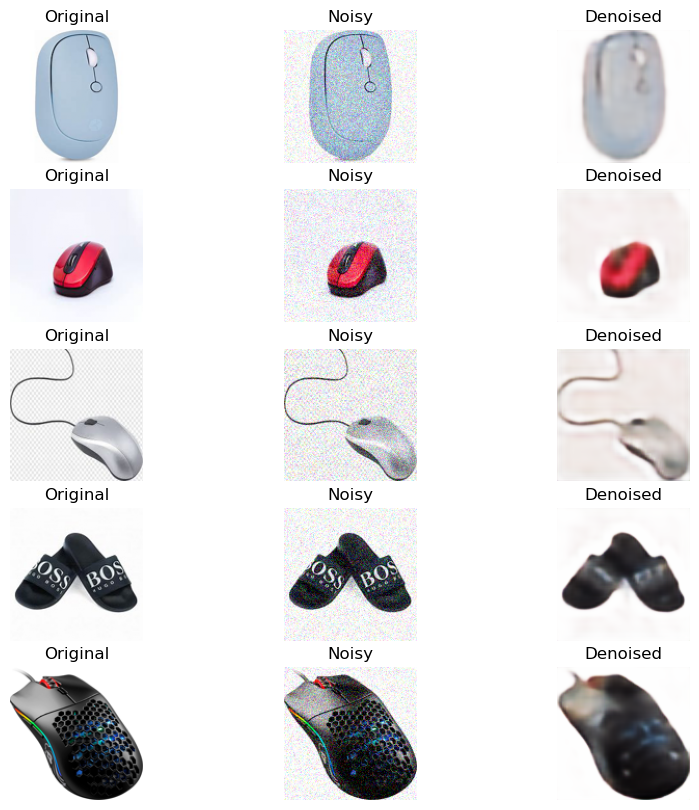

In [ ]:
def show_images(original, noisy, denoised, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 10))
    for i in range(num_images):
        axes[i, 0].imshow(original[i])
        axes[i, 0].set_title("Original")
        axes[i, 1].imshow(noisy[i])
        axes[i, 1].set_title("Noisy")
        axes[i, 2].imshow(denoised[i])
        axes[i, 2].set_title("Denoised")
        for ax in axes[i]:
            ax.axis("off")
    plt.show()

test_images_denoised = dae.predict(test_images_noisy_gaussian)
show_images(test_images, test_images_noisy_gaussian, test_images_denoised)


In [ ]:
# Subir imagenes al reporte


# Iniciar sesión en W&B
wandb.init(project="denoising-autoencoder", name="image_comparison")

def log_images(original, noisy, denoised, num_images=5):
    """Sube imágenes originales, ruidosas y restauradas a W&B"""
    images = []
    for i in range(num_images):
        img_grid = np.concatenate([original[i], noisy[i], denoised[i]], axis=1)  # Juntar horizontalmente
        images.append(wandb.Image(img_grid, caption=f"Original | Noisy | Denoised"))

    wandb.log({"Image Comparisons": images})

# Subir imágenes a W&B
log_images(test_images, test_images_noisy_gaussian, test_images_denoised)

# Finalizar la sesión de W&B
wandb.finish()

# Parte 3: Variational Autoencoder (VAE) para Generación de Imágenes


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
vae.save("vae_model_final.h5")

In [ ]:
dae.save("dae_model_final.h5")

## VAE FINAL

## Entrenamiento:



In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [21]:
# Parámetros del modelo
img_shape = (128, 128, 3)
latent_dim = 64

# ENCODER
def build_encoder():
    inputs = keras.Input(shape=img_shape)

    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    return keras.Model(inputs, [z_mean, z_log_var], name="encoder")

z_mean: Representa la media de la distribución latente.

z_log_var: Representa el logaritmo de la varianza de la distribución latente.

In [22]:
# REPARAMETRIZACIÓN
## En este caso se convierte z_mean y z_log_var en una variable latente z.

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Por qué hacemos esto?

Porque un VAE aprende distribuciones en lugar de puntos fijos, lo que permite generar imágenes nuevas en lugar de solo memorizar las originales.

In [23]:
# DECODER
def build_decoder():
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(16 * 16 * 128, activation="relu")(latent_inputs)
    x = layers.Reshape((16, 16, 128))(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)

    outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)  # Normalizado entre 0 y 1

    return keras.Model(latent_inputs, outputs, name="decoder")

In [24]:
# Definir el VAE
encoder = build_encoder()
decoder = build_decoder()

z_mean, z_log_var = encoder.output 
z = Sampling()([z_mean, z_log_var])

vae = keras.Model(encoder.input, decoder(z), name="vae")
vae.compile(optimizer="adam", loss="mse")

In [25]:
vae.fit(train_images, train_images, epochs=1000, batch_size=32, shuffle=True)

Epoch 1/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - loss: 0.1603
Epoch 2/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0758
Epoch 3/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0728
Epoch 4/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0667
Epoch 5/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0631
Epoch 6/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0566
Epoch 7/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0483
Epoch 8/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0440
Epoch 9/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0438
Epoch 10/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0408
Epoch 11/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0389
Epoch 12/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0372
Epoch 13/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0362
Epoch 14/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0357
Epoch 15/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 

In [55]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cosine

# Función para calcular el MSE entre la imagen original y la reconstrucción
def mse_metric(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Función para calcular la distancia coseno entre las imágenes originales y las reconstruidas
def cosine_distance_metric(y_true, y_pred):
    # Convertir las imágenes a un formato 1D
    y_true_flat = tf.reshape(y_true, (tf.shape(y_true)[0], -1))
    y_pred_flat = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1))

    # Calcular la distancia coseno en batch (por ejemplo, para cada imagen)
    cosine_distances = tf.map_fn(lambda x: cosine(x[0], x[1]), (y_true_flat, y_pred_flat), dtype=tf.float32)
    return tf.reduce_mean(cosine_distances)

In [58]:
# Usar el VAE para hacer predicciones (por ejemplo, usando un conjunto de datos de test)
reconstructed_images = vae.predict(test_images)

# Calcular las métricas
mean_original = np.mean(test_images, axis=(1, 2, 3))  # Promedio de las imágenes originales por cada imagen
mean_reconstructed = np.mean(reconstructed_images, axis=(1, 2, 3))  # Promedio de las imágenes reconstruidas

# Calcular distancia coseno
cosine_distance = cosine(mean_original, mean_reconstructed)
print(f"Distancia Coseno: {cosine_distance:.4f}")

# Calcular MSE
mse_distance = mean_squared_error(mean_original, mean_reconstructed)
print(f"Error Cuadrático Medio (MSE): {mse_distance:.4f}")


1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 952ms/step
Distancia Coseno: 0.0003
Error Cuadrático Medio (MSE): 0.0004


### mse_metric:

Calcula el error cuadrático medio entre las imágenes originales y las reconstruidas a nivel de pixel. Esto mide la diferencia entre las dos imágenes de manera más directa.

###  cosine_distance_metric:

 Mide la distancia coseno entre las imágenes, evaluando qué tan similares son las representaciones en el espacio de características. Esto se calcula después de aplanar las imágenes y también va de 0 a 1 siendo 1 lo más lejano a que se parezcan las imágenes reales vs las generadas

### GENERAR NUEVAS IMÁGENES

## Con 600

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


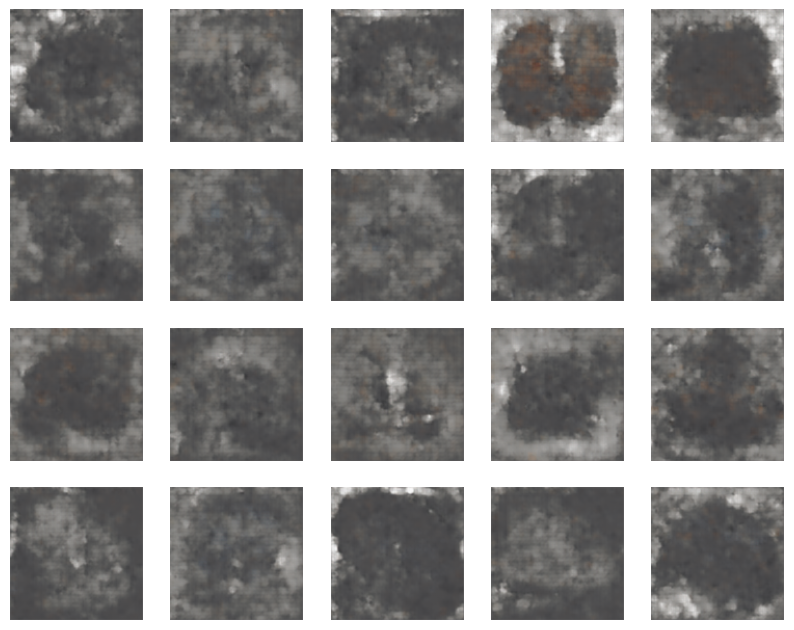

In [16]:
def generate_images(num_images=20):
    random_latent_vectors = np.random.normal(size=(num_images, latent_dim))
    generated_images = decoder.predict(random_latent_vectors)

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.show()

generate_images(20)

## Con 500

1/1 [==============================] - 0s 177ms/step


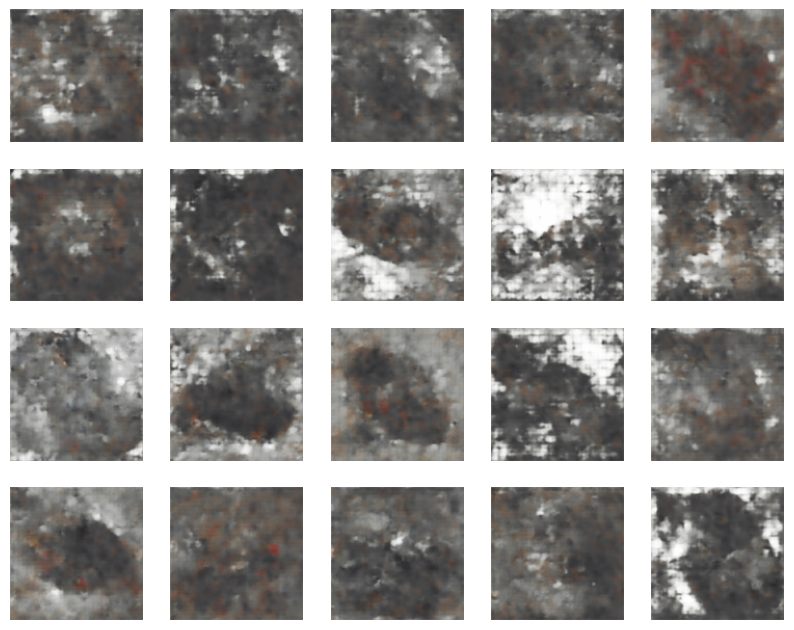

In [ ]:
def generate_images(num_images=20):
    random_latent_vectors = np.random.normal(size=(num_images, latent_dim))
    generated_images = decoder.predict(random_latent_vectors)

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.show()

generate_images(20)

## Con 100 epochs

1/1 [==============================] - 1s 686ms/step


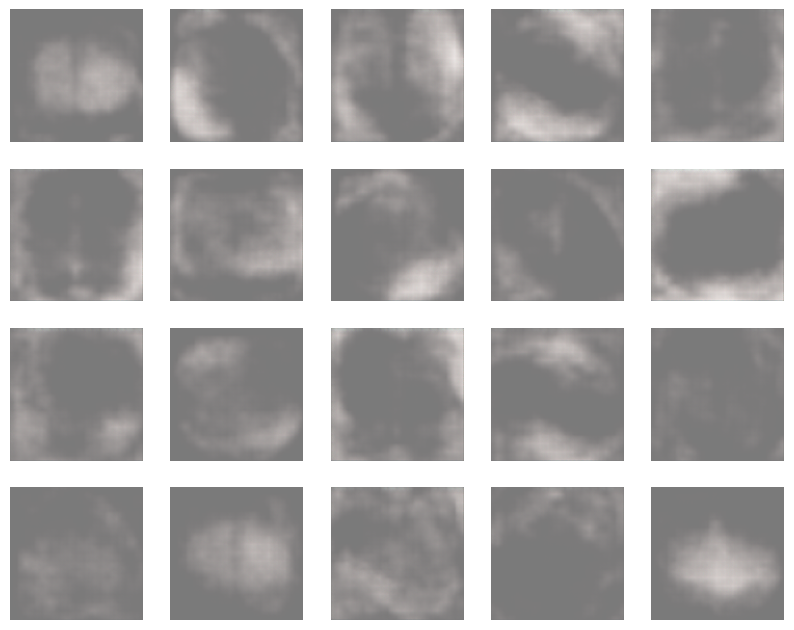

In [ ]:
def generate_images(num_images=20):
    random_latent_vectors = np.random.normal(size=(num_images, latent_dim))
    generated_images = decoder.predict(random_latent_vectors)

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.show()

generate_images(20)

### Con 200

1/1 [==============================] - 0s 180ms/step


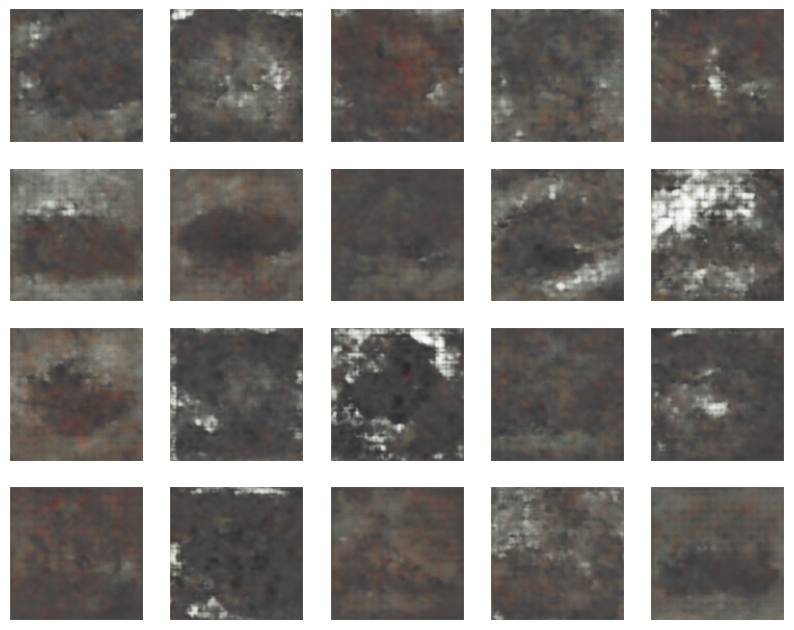

In [ ]:
def generate_images(num_images=20):
    random_latent_vectors = np.random.normal(size=(num_images, latent_dim))
    generated_images = decoder.predict(random_latent_vectors)

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.show()

generate_images(20)